In [55]:
# Install required packages
!pip install torch torch-geometric scikit-learn pandas networkx

In [56]:
# Upgrade pip
!pip install --upgrade pip

In [57]:
# Imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch_geometric.data import Data
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Load the Data and Preprocess

In [58]:
# Load the CSV data
student_data = pd.read_csv('synthetic_student_data.csv')

# Copy data for processing
student_data_processed = student_data.copy()

# Calculate Wellbeing Score
student_data_processed['Wellbeing_Score'] = (
    student_data_processed['pwi_wellbeing'] + student_data_processed['k6_overall']
) / 2

# Friendliness Score
student_data_processed['Friendliness_Score'] = student_data_processed['School_support_engage']

# Bullying Score
student_data_processed['Bullying_Score'] = student_data_processed['criticises']

# Normalize selected columns
scaler = MinMaxScaler()
cols_to_normalize = ['Academic_Performance', 'Wellbeing_Score', 'Friendliness_Score']
student_data_processed[cols_to_normalize] = scaler.fit_transform(
    student_data_processed[cols_to_normalize]
)

# Composite Score
student_data_processed['Composite_Score'] = (
    0.7 * student_data_processed['Academic_Performance'] +
    0.2 * student_data_processed['Wellbeing_Score'] +
    0.1 * student_data_processed['Friendliness_Score']
)

# Identify potential bullies
BULLY_THRESHOLD = 5
student_data_processed['Potential_Bully'] = student_data_processed['Bullying_Score'] > BULLY_THRESHOLD

# Preview processed data
preview_cols = [
    'StudentID', 'Academic_Performance', 'Wellbeing_Score',
    'Friendliness_Score', 'Bullying_Score', 'Composite_Score',
    'Potential_Bully'
]
student_data_processed[preview_cols].head()

,StudentID,Academic_Performance,Wellbeing_Score,Friendliness_Score,Bullying_Score,Composite_Score,Potential_Bully
0,S0001,0.035714,0.2500,0.666667,6,0.141667,True
1,S0002,0.767857,0.5000,0.476190,1,0.685119,False
2,S0003,0.285714,0.6250,0.476190,7,0.372619,True
3,S0004,0.571429,0.8125,0.809524,6,0.643452,True
4,S0005,0.803571,0.0000,0.809524,3,0.643452,False


## Build the Edge List

In [59]:
# Build a mapping from StudentID to row index
student_id_to_idx = {sid: idx for idx, sid in enumerate(student_data_processed['StudentID'])}

# Build the edge list
edge_index_list = []
for idx, row in student_data_processed.iterrows():
    if pd.notna(row['Friends']):
        friends = [f.strip() for f in row['Friends'].split(',')]
        for friend_id in friends:
            if friend_id in student_id_to_idx:
                edge_index_list.append([idx, student_id_to_idx[friend_id]])

# Convert to PyTorch tensor
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

print(f"Edge Index Shape: {edge_index.shape}")
print(f"Example Edges:\n{edge_index[:, :5]}")

Edge Index Shape: torch.Size([2, 209])
Example Edges:
tensor([[ 0,  0,  0,  0,  1],
        [28,  3, 36,  4, 26]])


## Build Node Features

In [60]:
# Select features for node representation
node_feature_cols = [
    'Academic_Performance', 'Wellbeing_Score',
    'Friendliness_Score', 'Bullying_Score',
    'Composite_Score'
]
node_features = student_data_processed[node_feature_cols].values

# Convert to PyTorch tensor
x = torch.tensor(node_features, dtype=torch.float)

print(f"Node Feature Shape: {x.shape}")

Node Feature Shape: torch.Size([50, 5])


## Build GNN Data Object

In [61]:
# Create PyG Data object
data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[50, 5], edge_index=[2, 209])


## Define a Simple 2-Layer GCN

In [62]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

## Initialize Model

In [63]:
# Initialize model and optimizer
INPUT_DIM = 5
HIDDEN_DIM = 16
OUTPUT_DIM = 2
LEARNING_RATE = 0.01

model = GCN(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()  # Dummy loss for unsupervised

In [64]:
# Forward pass (inference mode)
model.eval()
with torch.no_grad():
    out = model(data)

print(f"Output Embeddings Shape: {out.shape}")
print(f"Example Embedding for Student 0: {out[0]}")

Output Embeddings Shape: torch.Size([50, 2])
Example Embedding for Student 0: tensor([-2.4865, -0.9812])


## Visualize the GNN Outputs in 2D

## Basic Scatter Plot of Student Embeddings

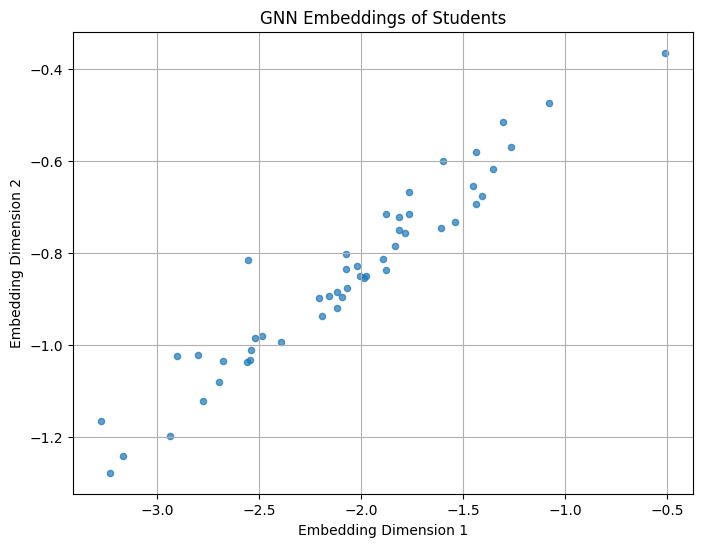

In [65]:
# Scatter plot of embeddings
plt.figure(figsize=(8, 6))
plt.scatter(out[:, 0].cpu(), out[:, 1].cpu(), s=20, alpha=0.7)
plt.title("GNN Embeddings of Students")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()

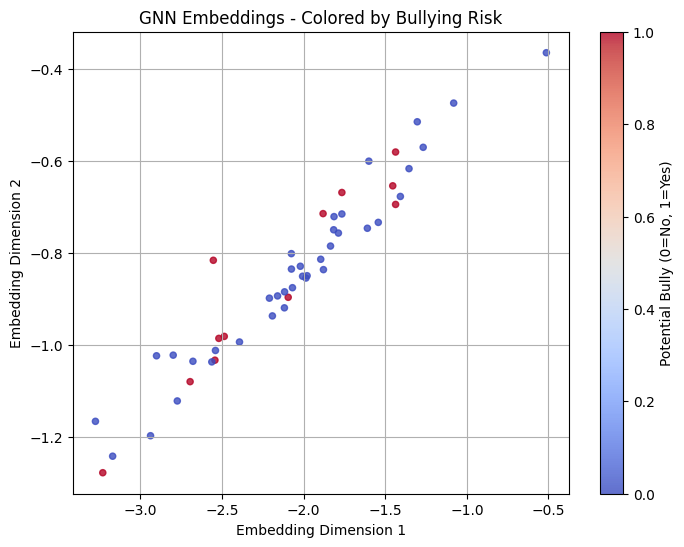

In [66]:
# Color by bully status
bully_labels = student_data_processed['Potential_Bully'].astype(int)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    out[:, 0].cpu(), out[:, 1].cpu(), c=bully_labels, cmap='coolwarm', s=20, alpha=0.8
)
plt.title("GNN Embeddings - Colored by Bullying Risk")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.colorbar(scatter, label="Potential Bully (0=No, 1=Yes)")
plt.grid(True)
plt.show()

In [67]:
# KMeans clustering for classroom assignment
NUM_CLASSES = 10
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=42)
student_clusters = kmeans.fit_predict(out.cpu().numpy())

student_data_processed['Assigned_Classroom'] = student_clusters
student_data_processed[['StudentID', 'Assigned_Classroom']].head()

,StudentID,Assigned_Classroom
0,S0001,4
1,S0002,0
2,S0003,1
3,S0004,3
4,S0005,8


In [68]:
# Classroom summary statistics
classroom_summary = student_data_processed.groupby('Assigned_Classroom').agg({
    'Academic_Performance': 'mean',
    'Wellbeing_Score': 'mean',
    'Friendliness_Score': 'mean',
    'Potential_Bully': 'sum',  # count how many potential bullies
    'StudentID': 'count'  # total students
}).rename(columns={'StudentID': 'Class_Size'})

classroom_summary

,Academic_Performance,Wellbeing_Score,Friendliness_Score,Potential_Bully,Class_Size
Assigned_Classroom,,,,,
0,0.531746,0.513889,0.560847,3,9
1,0.401786,0.666667,0.658730,1,6
2,0.678571,0.500000,0.619048,0,1
3,0.457589,0.445312,0.547619,2,8
4,0.566327,0.562500,0.578231,4,7
5,0.178571,0.500000,0.571429,0,1
6,0.482143,0.062500,0.428571,0,1
7,0.363095,0.625000,0.539683,1,3
8,0.359127,0.666667,0.661376,0,9


In [69]:
# --- Full Constraint Evaluation After GNN Clustering ---

# Constraint Thresholds
MAX_ACADEMIC_DIFF = 15  # Academic score max diff
MAX_WELLBEING_DIFF = 2  # Wellbeing score max diff
MAX_BULLIES_PER_CLASS = 2  # Max allowed bullies per class

# 1. Check Academic Score Balance
academic_diff = classroom_summary['Academic_Performance'].max() - classroom_summary['Academic_Performance'].min()
print(f"Academic Score Difference: {academic_diff:.2f} (Limit: {MAX_ACADEMIC_DIFF})")
if academic_diff > MAX_ACADEMIC_DIFF:
    print("❌ Academic score balance constraint violated.")
else:
    print("✅ Academic score balance constraint satisfied.")

# 2. Check Wellbeing Balance
wellbeing_diff = classroom_summary['Wellbeing_Score'].max() - classroom_summary['Wellbeing_Score'].min()
print(f"Wellbeing Score Difference: {wellbeing_diff:.2f} (Limit: {MAX_WELLBEING_DIFF})")
if wellbeing_diff > MAX_WELLBEING_DIFF:
    print("❌ Wellbeing balance constraint violated.")
else:
    print("✅ Wellbeing balance constraint satisfied.")

# 3. Check Bullying Spread Constraint
violating_classes = classroom_summary[classroom_summary['Potential_Bully'] > MAX_BULLIES_PER_CLASS]
if not violating_classes.empty:
    print(f"❌ {len(violating_classes)} classroom(s) exceed the bullying constraint.")
    print(violating_classes[['Potential_Bully']])
else:
    print("✅ Bullying spread constraint satisfied.")

# 4. Check Class Size Balance
class_sizes = classroom_summary['Class_Size']
size_diff = class_sizes.max() - class_sizes.min()
print(f"Class Size Range: {class_sizes.min()} - {class_sizes.max()} (Diff = {size_diff})")
if size_diff > 10:
    print("⚠️ Warning: Significant difference in class sizes.")
else:
    print("✅ Class sizes are reasonably balanced.")

Academic Score Difference: 0.50 (Limit: 15)
✅ Academic score balance constraint satisfied.
Wellbeing Score Difference: 0.65 (Limit: 2)
✅ Wellbeing balance constraint satisfied.
❌ 2 classroom(s) exceed the bullying constraint.
                    Potential_Bully
Assigned_Classroom                 
0                                 3
4                                 4
Class Size Range: 1 - 9 (Diff = 8)
✅ Class sizes are reasonably balanced.


In [70]:
# KMeans clustering (repeat for demonstration)
NUM_CLASSES = 10
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=42)
student_clusters = kmeans.fit_predict(out.cpu().numpy())
student_data_processed['Assigned_Classroom'] = student_clusters
student_data_processed[['StudentID', 'Assigned_Classroom']].head()

,StudentID,Assigned_Classroom
0,S0001,4
1,S0002,0
2,S0003,1
3,S0004,3
4,S0005,8


In [71]:
# Summarize classroom stats
classroom_summary = student_data_processed.groupby('Assigned_Classroom').agg({
    'Academic_Performance': 'mean',
    'Wellbeing_Score': 'mean',
    'Friendliness_Score': 'mean',
    'Potential_Bully': 'sum',  # how many bullies in each class
    'StudentID': 'count'  # class size
}).rename(columns={'StudentID': 'Class_Size'})

classroom_summary

,Academic_Performance,Wellbeing_Score,Friendliness_Score,Potential_Bully,Class_Size
Assigned_Classroom,,,,,
0,0.531746,0.513889,0.560847,3,9
1,0.401786,0.666667,0.658730,1,6
2,0.678571,0.500000,0.619048,0,1
3,0.457589,0.445312,0.547619,2,8
4,0.566327,0.562500,0.578231,4,7
5,0.178571,0.500000,0.571429,0,1
6,0.482143,0.062500,0.428571,0,1
7,0.363095,0.625000,0.539683,1,3
8,0.359127,0.666667,0.661376,0,9


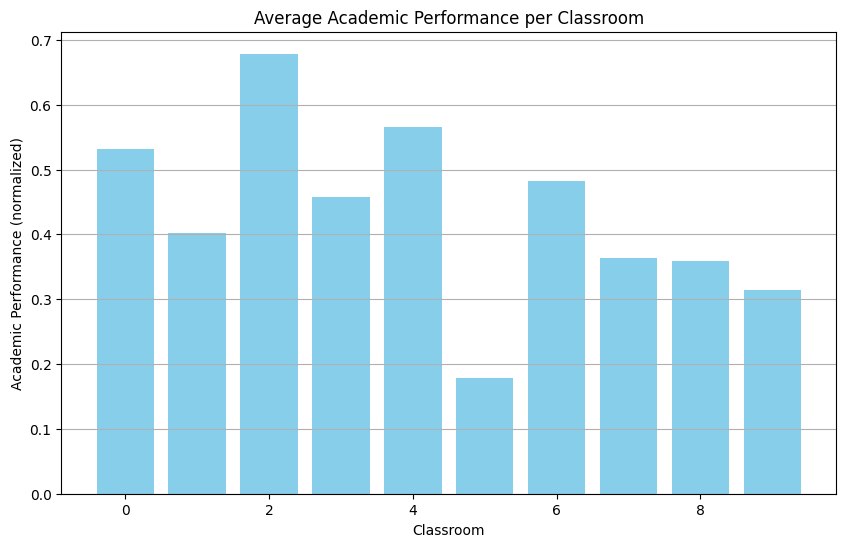

In [72]:
# Plot average academic performance per classroom
plt.figure(figsize=(10, 6))
plt.bar(classroom_summary.index, classroom_summary['Academic_Performance'], color='skyblue')
plt.title('Average Academic Performance per Classroom')
plt.xlabel('Classroom')
plt.ylabel('Academic Performance (normalized)')
plt.grid(axis='y')
plt.show()

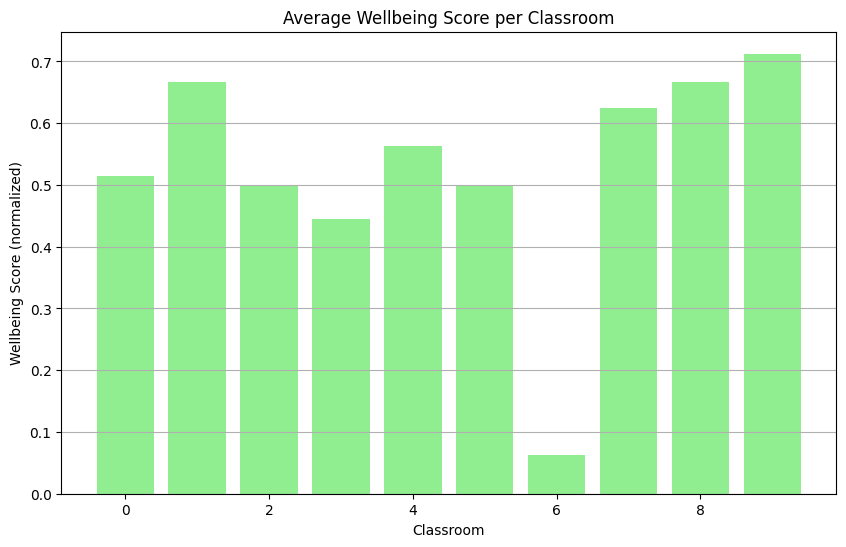

In [73]:
# Plot average wellbeing score per classroom
plt.figure(figsize=(10, 6))
plt.bar(classroom_summary.index, classroom_summary['Wellbeing_Score'], color='lightgreen')
plt.title('Average Wellbeing Score per Classroom')
plt.xlabel('Classroom')
plt.ylabel('Wellbeing Score (normalized)')
plt.grid(axis='y')
plt.show()

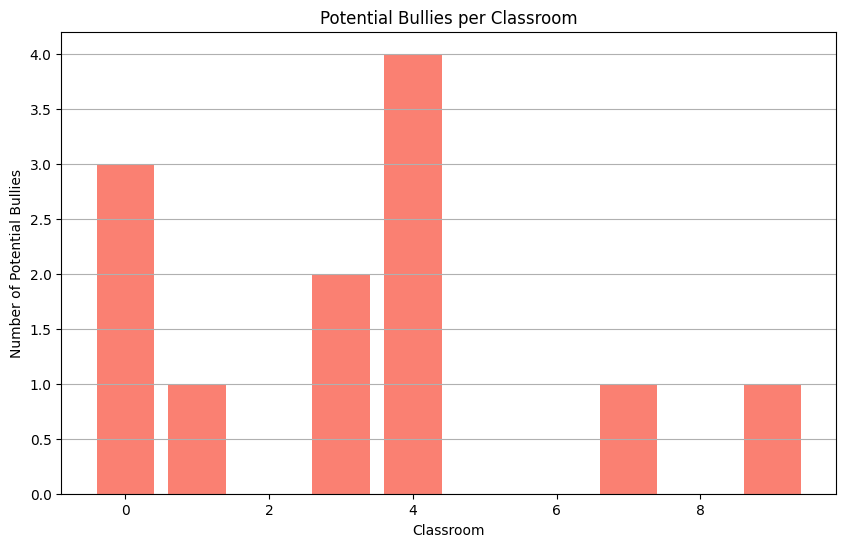

In [74]:
# Plot number of potential bullies per classroom
plt.figure(figsize=(10, 6))
plt.bar(classroom_summary.index, classroom_summary['Potential_Bully'], color='salmon')
plt.title('Potential Bullies per Classroom')
plt.xlabel('Classroom')
plt.ylabel('Number of Potential Bullies')
plt.grid(axis='y')
plt.show()

In [75]:
# Calculate silhouette score based on GNN embeddings and assigned classroom
sil_score = silhouette_score(out.cpu().numpy(), student_data_processed['Assigned_Classroom'])
print(f"Silhouette Score for GNN + KMeans Grouping: {sil_score:.4f}")

Silhouette Score for GNN + KMeans Grouping: 0.4293


In [76]:
# Calculate std deviation across classrooms
classroom_variance = classroom_summary[[
    'Academic_Performance', 'Wellbeing_Score', 'Friendliness_Score'
]].std()

print("Standard Deviation Across Classrooms:")
print(classroom_variance)

Standard Deviation Across Classrooms:
Academic_Performance    0.141812
Wellbeing_Score         0.185091
Friendliness_Score      0.069336
dtype: float64


In [77]:
# (Empty cell for future use)